In [1]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../')

from matplotlib.colors import LogNorm
from src.viz import plot_trajectories, use_mpl_scatter_density, plot_transition_matrix,plot_implied_timescales
from src.io import load_dataframe, save_dataframe
from src.preprocessing import (compute_phases,split_trajectories,filter_trajectories,smooth_trajectory_savgol)
from src.embedding import Embedding
from src.markov_analysis import MarkovAnalysis
from src.embedding_position import EmbeddingPosition
from umap import UMAP
from src.preprocessing import reconstruct_trajectory_from_angles

from scipy.spatial import Voronoi, voronoi_plot_2d
from src.trajectory_utils import canonicalize_trajectory

In [2]:
df = pd.read_parquet('../data/toy_model/interim/phases.parquet')
print(df.shape)
df.head()

(99700, 10)


x         y         z  label  frame move_type  speed  \
0 -0.232717  0.602229  1.892925      1      1  straight    2.0   
1 -0.465433  1.204457  3.785849      1      2  straight    2.0   
2 -0.698150  1.806686  5.678774      1      3  straight    2.0   
3 -0.930867  2.408915  7.571698      1      4  straight    2.0   
4 -1.163583  3.011144  9.464623      1      5  straight    2.0   

   curvature_angle  torsion_angle  abs_torsion_angle  
0     1.490116e-08      -1.570796           1.570796  
1     0.000000e+00      -1.570796           1.570796  
2     0.000000e+00       1.570796           1.570796  
3     0.000000e+00       1.570796           1.570796  
4     1.490116e-08       1.570797           1.570797

/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


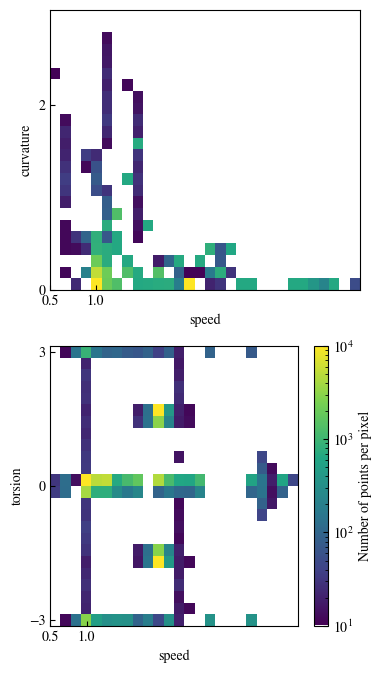

In [3]:
#plt.scatter(df[df['label'] ==1]['speed'],df[df['label'] ==1]['curvature_angle'],marker='o',alpha=0.1)
fig = plt.figure(figsize=(4,8))
norm = LogNorm(vmin=1e1,vmax=10**4)
ax1 = use_mpl_scatter_density(fig, df['speed'],df['curvature_angle'],dpi=10,norm=norm,nrows=2,pos=1,colorbar=None)
ax1.set_xlabel('speed')
ax1.set_ylabel('curvature')
ax1.set_xticks([0.5,1.])
ax1.set_yticks([0.,2.])
#ax1.grid()
ax2 = use_mpl_scatter_density(fig, df['speed'],df['torsion_angle'],dpi=10,norm=norm,nrows=2,pos=2)
ax2.set_xlabel('speed')
ax2.set_ylabel('torsion')
ax2.set_xticks([0.5,1])
ax2.set_yticks([-3,0,3])
#ax2.grid()
#fig.savefig('phase_space_toy_model.svg',transparent=True,bbox_inches='tight')

In [4]:
#emb = Embedding(df,
#                columns=['speed','curvature_angle','abs_torsion_angle'],
#                ID_NAME='label')
#emb = EmbeddingPosition(df,columns=['speed'],columns_translated=['x','y','z'],ID_NAME='label')
emb = EmbeddingPosition(df,columns=[],columns_translated=['x','y','z'],ID_NAME='label',n_subsample=10000)
#emb = Embedding(df,
#                columns=['speed','curvature_angle'],ID_NAME='label')


In [ ]:
emb.make_embedding(K=40)

In [ ]:
emb.make_cluster(100)#,clustering_method='polynomial_distances')

array([ 3, 11,  3, ..., 10, 10, 10])

In [ ]:
# Label the rest by nearest center
#from scipy.spatial.distance import cdist
#dists = cdist(emb.flatten_embedding_matrix, emb.cluster_centers_, metric='euclidean')
#emb.labels = np.argmin(dists, axis=1)
#self.cluster_centers_ = centers
#return self.labels

10
10


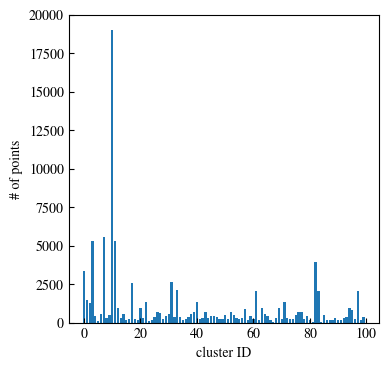

In [ ]:
# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
# Optionally, zip into a dict
cluster_counts = dict(zip(unique_labels, counts))
fig,ax = plt.subplots(figsize=(4,4))
ax.bar(list(cluster_counts.keys()),list(cluster_counts.values()))
ax.set_xlabel('cluster ID')
ax.set_ylabel('# of points')
print(unique_labels[np.argmax(counts)])
print(np.argmax(counts))

In [ ]:
reduced_points,reduced_centers = emb.fit_umap(n_neighbors=15,min_dist=0.5,with_cluster_centers=True)

/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


rng = np.random.default_rng(10973)
print(emb.flatten_embedding_matrix.shape[0])
indices = rng.choice(emb.flatten_embedding_matrix.shape[0], size=9680, replace=False)
data = emb.flatten_embedding_matrix[indices]
    
combined =np.array([])
# Concatenate data and centers before UMAP
combined = np.append(data, emb.cluster_centers_, axis=0)
reducer = UMAP(
        n_neighbors=10,
        min_dist=0.5,
        n_components=2,
        metric="euclidean",
    )
reduced_all = reducer.fit_transform(combined)
N = data.shape[0]
reduced_points = reduced_all[:N]
reduced_centers = reduced_all[N:N + emb.cluster_centers_.shape[0]]

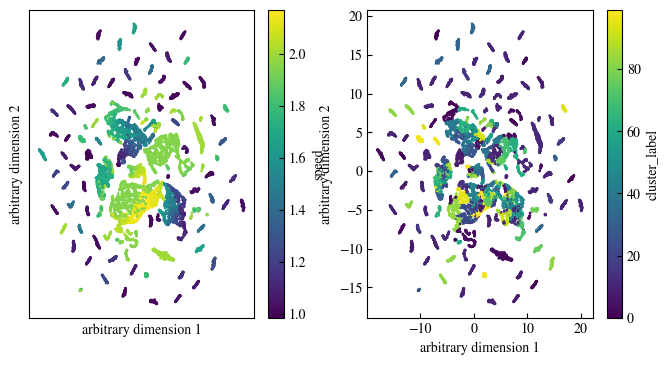

In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))

speedx = emb.flatten_embedding_matrix[emb.indices,0::3][:,1:] - emb.flatten_embedding_matrix[emb.indices,0::3][:,:-1]
speedy = emb.flatten_embedding_matrix[emb.indices,1::3][:,1:] - emb.flatten_embedding_matrix[emb.indices,1::3][:,:-1]
speedz = emb.flatten_embedding_matrix[emb.indices,2::3][:,1:] - emb.flatten_embedding_matrix[emb.indices,2::3][:,:-1]
speed = np.mean(np.linalg.norm(np.array([speedx,speedy,speedz]).T,axis=2),axis=0)
color_values=speed
#color_values = np.mean(emb.flatten_embedding_matrix[indices, 0::4], axis=1)
sc = ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1,rasterized=True)
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
    
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
cbar = fig.colorbar(sc, ax=ax[0])
cbar.set_label(r'speed')
#cbar.ax.set_yticks([])  

color_values = np.mean(emb.flatten_embedding_matrix[emb.indices, 1::3], axis=1)
color_values = emb.labels[emb.indices]
sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1,rasterized=True)
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
#ax[1].set_xticks([])
#ax[1].set_yticks([])
ax[1].set_xlabel('arbitrary dimension 1')
ax[1].set_ylabel('arbitrary dimension 2')
cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label(r'cluster_label')
#cbar.ax.set_yticks([])  

#for i in range(2):
#    ax[i].set_xlim(-2,15)
#    ax[i].set_ylim(-2,10)

In [ ]:
mkv = MarkovAnalysis(emb)

In [ ]:
lambda_tau =[]
taus = np.array([1,2,3,4,5,10,15,20,25,30,40,50,100,200,300,500])
for tau in taus:
    mkv.make_transition_matrix(tau=tau)
    mkv.compute_spectrum()
    lambda_tau.append(np.real(mkv.val[max(-10,-mkv.val.shape[0]):]))

    #eig_val,eig_vec = np.linalg.eig(mkv.P.T)
    #real_spectrum = np.abs(np.real(eig_val))
    #eig_vec = eig_vec[:,np.argsort(real_spectrum)]#/np.sum(eig_vec[:,np.argsort(real_spectrum)],axis=1)
    #real_spectrum = real_spectrum[np.argsort(real_spectrum)]
    #lambda_tau.append(real_spectrum[-10:])
lambda_tau=np.array(lambda_tau)

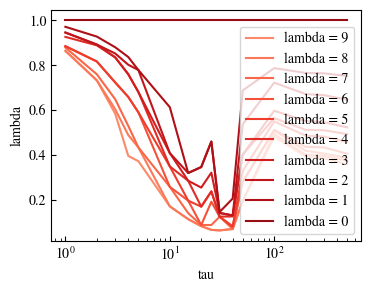

In [ ]:
from matplotlib import cm 
colors = cm.Reds(np.linspace(0.4, 0.9, 10))  # Gradient from light to dark red
fig,ax = plt.subplots(figsize=(4,3))
for i in range(min([10,mkv.val.shape[0]])):
    ax.plot(taus,lambda_tau[:,i],label="lambda = "+str(9-i),color=colors[i])
ax.set_xscale('log')
ax.set_xlabel("tau")
ax.set_ylabel('lambda')
ax.legend()

In [ ]:
mkv.make_transition_matrix(tau=5)
mkv.reversibilized_matrix()
mkv.compute_spectrum()
mkv.compute_tr_spectrum()

ss = (np.real(mkv.tr_vec[:,-1]))
ss = ss/np.sum(ss)

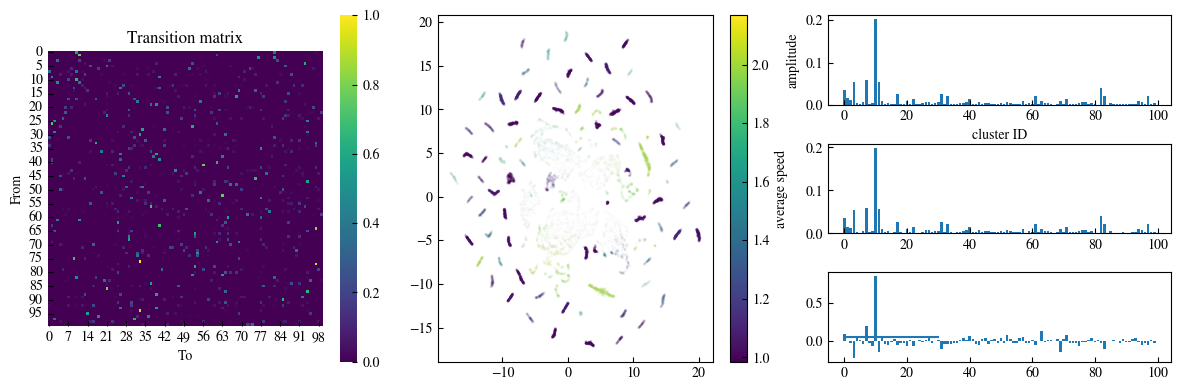

In [ ]:
# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))
count_for_color = np.array(list(cluster_counts.values()))/np.sum(list(cluster_counts.values()))

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1,1], width_ratios=[1, 1, 1])
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[:,1])
ax02 = fig.add_subplot(gs[0,2])
ax12 = fig.add_subplot(gs[1,2])
ax22 = fig.add_subplot(gs[2,2])


plot_transition_matrix(mkv.P, ax=ax0)
plt.tight_layout()

color_values = speed#np.mean(emb.flatten_embedding_matrix[indices, 0::4], axis=1)
alpha = [count_for_color[lab] for lab in emb.labels[emb.indices]]
sc = ax1.scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=alpha,rasterized=True,cmap='viridis')
cbar = fig.colorbar(sc, ax=ax1)
cbar.set_label('average speed')

ax02.bar(np.arange(0,ss.shape[0],1),ss)
ax02.set_xlabel('cluster ID')
ax02.set_ylabel('amplitude')


ax12.bar(list(cluster_counts.keys()),np.array(list(cluster_counts.values()))/np.sum(list(cluster_counts.values())))

#slow = slow/np.sum(slow)
ax22.bar(np.arange(0,mkv.slow_mode.shape[0],1),mkv.slow_mode)
ax22.plot([0,30],[0.05,0.05])

plt.show()

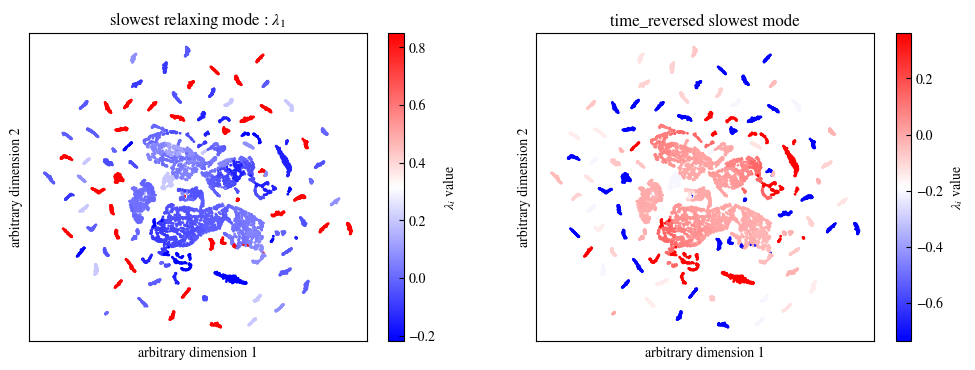

In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(12,4))
color_values = [mkv.slow_mode[lab] for lab in emb.labels[emb.indices]]
sc = ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
cbar = fig.colorbar(sc, ax=ax[0])
cbar.set_label(r'$\lambda_i$ value')

vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
ax[0].set_title(r'slowest relaxing mode : $\lambda_1$')

#slow_mode = np.real(vec[:,-3])
#color_values = [slow_mode[lab] for lab in emb.labels[emb.indices]]
#sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
#vor = Voronoi(reduced_centers)
##voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
#ax[1].set_xticks([])
#ax[1].set_yticks([])
#ax[1].set_xlabel('arbitrary dimension 1')
#ax[1].set_ylabel('arbitrary dimension 2')
#ax[1].set_title(r'second slowest relaxing mode : $\lambda_2$')

#cbar = fig.colorbar(sc, ax=ax[1])
#cbar.set_label(r'$\lambda_i$ value')
#ax.set_yticks([])  

color_values = [mkv.tr_slow_mode[lab] for lab in emb.labels[emb.indices]]
sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('arbitrary dimension 1')
ax[1].set_ylabel('arbitrary dimension 2')
ax[1].set_title(r'time_reversed slowest mode')

cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label(r'$\lambda_i$ value')

#cbar.ax.set_yticks([])  
#fig.savefig('umap_color_lambda.svg',transparent=True,bbox_inches='tight')

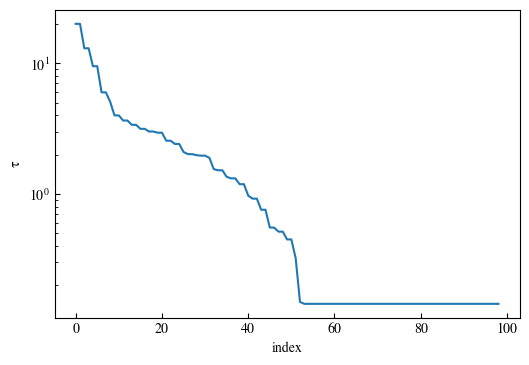

In [ ]:
ts = mkv.implied_timescales(tau=mkv.tau)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ts,label='stoch mat')
ax.set_ylabel("τ")
ax.set_xlabel("index")
plt.yscale('log')

emb.make_transition_matrix(tau=1)
state_trajectory = list()
emb.initialize_state()
state_trajectory.append(emb.state)
for i in range(5):
    emb.make_transition()
    state_trajectory.append(emb.state)
state_trajectory=np.array(state_trajectory)
print(state_trajectory.shape)

trajectory = list()
for points in state_trajectory:
    piece_of_trajectory = emb.pick_random_trajectory_in_cluster(points)
    trajectory.append(piece_of_trajectory)
trajectory = np.array(trajectory)
print(trajectory.shape)

XYZ = np.array([[0., 0., 0.]], dtype=float)
for traj in trajectory:
    # traj assumed to be flat array of length 3N
    coords = np.array([traj[0::3], traj[1::3], traj[2::3]])  # shape (3, N)
    coords = coords.T + XYZ[-1]  # shape (N, 3) + (3,) — this broadcasts correctly
    XYZ = np.vstack([XYZ, coords])
print(XYZ.shape)

fig,ax = plt.subplots(ncols=1,figsize=(8,4),subplot_kw={'projection':'3d'})
tint = trajectory.shape[1]//2 # phase_trajectory.shape[1] contains x and y
ax.plot(XYZ[:,0],XYZ[:,1],XYZ[:,2])#,marker='o')


In [ ]:
df1 = pd.read_csv('../data/toy_model/interim/longest_trajectory.csv')
df1.head()
print(df1[['x','y','z']].to_numpy().shape)
print(emb.D)
#labels = emb.classify_trajectory(trajectory_trans=df1[['x','y','z']].to_numpy(),trajectory_abs=np.array([df1['speed'].to_numpy()]).T)
labels = emb.classify_trajectory(trajectory_trans=df1[['x','y','z']].to_numpy())

(997, 3)
3


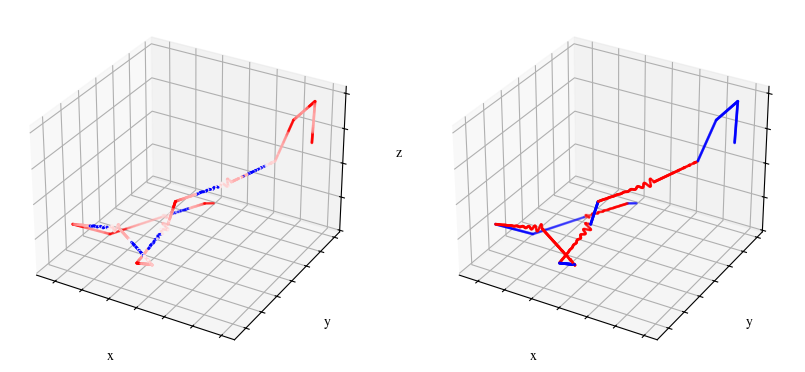

In [ ]:
fig,ax = plt.subplots(ncols = 2, subplot_kw={'projection':'3d'},figsize=(10,5))


color_values = [(mkv.tr_slow_mode[lab]) for lab in labels]
I = color_values.__len__()
ax[0].scatter(df1['x'][:I],df1['y'][:I],df1['z'][:I],c=color_values,cmap='bwr',s=1)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_zlabel('z')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_zticklabels([])
ax[0].grid(True)

#slow_mode = np.real(eig_vec[:,-4])
#color_values = [abs(slow_mode[lab]) for lab in labels]
I = labels.shape[0]
color_dict = {"straight":0.,"cast_and_surge":1.}
color_values = np.zeros(I,dtype=float)
for i in range(color_values.shape[0]):
    color_values[i] = color_dict[df1['move_type'][i]]
ax[1].scatter(df1['x'][:I],df1['y'][:I],df1['z'][:I],c=color_values,cmap='bwr',s=1.)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_zlabel('z')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_zticklabels([])
ax[1].grid(True)


from src.trajectory_utils import metastability
    
def compute_metastability(V,threshold,P,pi,upper=True):
        if upper:
            index = np.argwhere(V>=threshold)[:,0]
        else:
            index = np.argwhere(V<threshold)[:,0]
        return metastability(P,pi,index)

thresholds = np.linspace(min(slow_mode),max(slow_mode),100)
metastabilities = list()
metastabilities_R = list()
for threshold in thresholds:
    metastabilities.append(compute_metastability(slow_mode,threshold,emb.P,emb.pi,upper=True))
    metastabilities_R.append(compute_metastability(slow_mode,threshold,emb.P,emb.pi,upper=False))
metastabilities = np.array(metastabilities)
metastabilities_R = np.array(metastabilities_R)

In [ ]:
meta_in,meta_out = mkv.compute_metastability()


NameError: name 'thresholds' is not defined

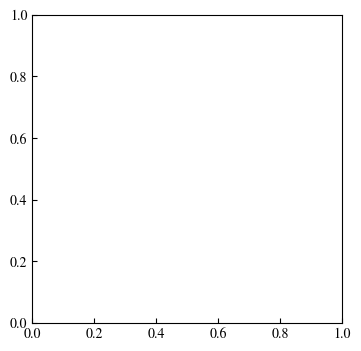

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(mkv.thresholds,mkv.meta_in,label=r'higher than threshold $\phi_2$ values')
ax.plot(mkv.thresholds,mkv.meta_out,label=r'lower than threshold $\phi_2$ values')
ax.set_xlabel('threshold')
ax.set_ylabel('metastability')
ax.legend()

# select a threshold "by hand" : 0

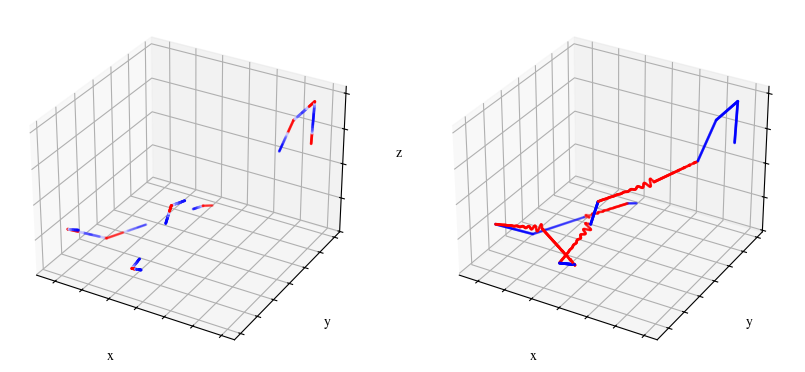

In [ ]:
fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': '3d'}, figsize=(10, 5))

slow_mode = np.real(vec[:, -2])
color_values = np.array([slow_mode[lab] for lab in labels])
mask = color_values > 0

df1_filtered = df1.iloc[:len(color_values)].reset_index(drop=True)
x = df1_filtered['x'][mask]
y = df1_filtered['y'][mask]
z = df1_filtered['z'][mask]
c = color_values[mask]

ax[0].scatter(x, y, z, c=c, cmap='bwr', s=1)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_zlabel('z')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_zticklabels([])
ax[0].grid(True)


I = labels.shape[0]
color_dict = {"straight":0.,"cast_and_surge":1.}
color_values = np.zeros(I,dtype=float)
for i in range(color_values.shape[0]):
    color_values[i] = color_dict[df1['move_type'][i]]
ax[1].scatter(df1['x'][:I],df1['y'][:I],df1['z'][:I],c=color_values,cmap='bwr',s=1.)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_zlabel('z')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_zticklabels([])
ax[1].grid(True)


In [ ]:
trajectory = df1[['x','y','z']].to_numpy()
L = trajectory.shape[0] - emb.K
embedded_trajectory = np.empty((L, emb.K * emb.D), dtype=float)
for t in range(L):
    embedded_trajectory[t] = canonicalize_trajectory(trajectory[t:t + emb.K]).reshape(-1)

In [ ]:
print(emb.n_clusters)

100


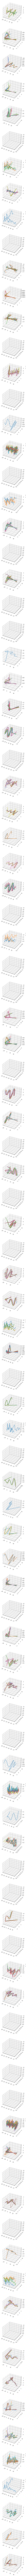

In [ ]:
fig,ax = plt.subplots(nrows = emb.n_clusters,subplot_kw={'projection':'3d'},figsize=(4,4*emb.n_clusters))
for n,traj in enumerate(embedded_trajectory):
    ax[labels[n]].plot(traj[0::3],traj[1::3],traj[2::3])

<BarContainer object of 100 artists>

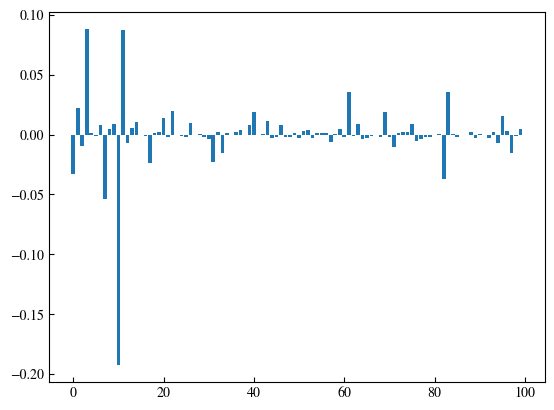

In [ ]:
slow_mode = np.real(vec[:,-2])
slow_mode = (slow_mode)/np.sum(np.abs(slow_mode))
#slow_mode = (slow_mode - np.min(slow_mode))/(np.max(slow_mode) - np.min(slow_mode))
plt.bar(np.arange(0,slow_mode.shape[0],1),slow_mode)

In [ ]:
index = np.argwhere(slow_mode>.1)[:,0]
print(index.shape)
print(emb.P.shape)
print(emb.P[index].shape)
print(emb.P[np.ix_(index,index)])

(0,)
(100, 100)
(0, 100)
[]


In [ ]:
np.cumsum(slow_mode[np.argsort(slow_mode)][::-1])

array([8.82363626e-02, 1.75640793e-01, 2.11227914e-01, 2.46785379e-01,
       2.69314644e-01, 2.89111783e-01, 3.08147220e-01, 3.26663959e-01,
       3.42171727e-01, 3.56101792e-01, 3.67272141e-01, 3.78039093e-01,
       3.87849206e-01, 3.96830244e-01, 4.05759233e-01, 4.14487412e-01,
       4.22602193e-01, 4.30697431e-01, 4.38469003e-01, 4.43782097e-01,
       4.48752210e-01, 4.53535678e-01, 4.58122799e-01, 4.62027098e-01,
       4.65781061e-01, 4.68992976e-01, 4.71976654e-01, 4.74485897e-01,
       4.76874309e-01, 4.79214543e-01, 4.81415391e-01, 4.83341487e-01,
       4.85228051e-01, 4.87077930e-01, 4.88614747e-01, 4.90147450e-01,
       4.91663010e-01, 4.93031036e-01, 4.94330177e-01, 4.95523176e-01,
       4.96561893e-01, 4.97503573e-01, 4.98354158e-01, 4.98881057e-01,
       4.99338980e-01, 4.99622619e-01, 4.99847305e-01, 4.99960861e-01,
       5.00000000e-01, 4.99939429e-01, 4.99807967e-01, 4.99672110e-01,
       4.99499457e-01, 4.99268845e-01, 4.99001397e-01, 4.98555711e-01,
      

In [ ]:
from src.labeling_cluster import embed_move_type, average_out, label_clusters


In [ ]:
Counter(emb.labels).keys().__len__()

100

In [ ]:
embedded_stereo = embed_move_type(df,K=emb.K,ID_NAME='label')

In [ ]:
embedded_counter = average_out(embedded_stereo,emb.K)

In [ ]:
stereotyps = label_clusters(n_clusters = emb.n_clusters, labels = emb.labels,embedded_counter = embedded_counter)

In [ ]:
print(stereotyps)
print(stereotyps[:6])


[{'straight': 0.007396891811117754, 'cast_and_surge': 0.9926031081888822}, {'straight': 0.8891604855023598, 'cast_and_surge': 0.11083951449764019}, {'straight': 0.011959876543209867, 'cast_and_surge': 0.9880401234567902}, {'straight': 0.9927044084400904, 'cast_and_surge': 0.007295591559909541}, {'straight': 0.4586470588235297, 'cast_and_surge': 0.5413529411764704}, {'straight': 0.0, 'cast_and_surge': 1.0}, {'straight': 0.81075, 'cast_and_surge': 0.18925}, {'straight': 0.00930263866451265, 'cast_and_surge': 0.9906973613354872}, {'straight': 1.0, 'cast_and_surge': 0.0}, {'straight': 1.0, 'cast_and_surge': 0.0}, {'straight': 0.0018351873229089993, 'cast_and_surge': 0.9981648126770909}, {'straight': 0.9944444444444445, 'cast_and_surge': 0.005555555555555563}, {'straight': 0.06331658291457265, 'cast_and_surge': 0.9366834170854275}, {'straight': 1.0, 'cast_and_surge': 0.0}, {'straight': 1.0, 'cast_and_surge': 0.0}, {'straight': 0.22164804469273747, 'cast_and_surge': 0.7783519553072626}, {'st

In [ ]:
def entropy(w):
    w = np.asarray(w, dtype=float)
    w = w[w > 0]  # avoid log(0)
    return -np.sum(w * np.log(w))/np.log(len(w))


In [ ]:
vals = list(stereotyps[0].values())
keys = list(stereotyps[0].keys())
print(vals)
print(keys)


[0.007396891811117754, 0.9926031081888822]
['straight', 'cast_and_surge']


In [ ]:
entropies_clusters = list()
for stereotyp in stereotyps:
    entropies_clusters.append(entropy(list(stereotyp.values())))
entropies_clusters=np.array(entropies_clusters)

/tmp/ipykernel_16457/941181060.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return -np.sum(w * np.log(w))/np.log(len(w))


In [ ]:
entropies_clusters[np.argsort(entropies_clusters)]
print(ss[np.argsort(entropies_clusters)])
print(sum(ss[:11]))

[0.00361722 0.0264693  0.20141233 0.02649967 0.00297564 0.0022378
 0.05335985 0.04053638 0.00709479 0.05372596 0.03516068 0.00176598
 0.05875271 0.00291516 0.01317132 0.0210776  0.02102838 0.00334826
 0.00275556 0.01004692 0.00377462 0.0061726  0.00526942 0.00221729
 0.02200559 0.00350242 0.02163667 0.00460776 0.00604867 0.01477414
 0.00226228 0.00720248 0.00421342 0.0093711  0.01065849 0.00500481
 0.01572519 0.01411068 0.00197623 0.00482495 0.00756756 0.00144277
 0.00518998 0.00184754 0.00509948 0.01038239 0.00228977 0.00286493
 0.00767922 0.00194626 0.0005053  0.00505914 0.0140823  0.00631344
 0.00188846 0.00204242 0.00720219 0.00278252 0.00414726 0.0021008
 0.00244121 0.00463953 0.00426605 0.00580555 0.00300247 0.00716485
 0.00037784 0.00374996 0.00175314 0.00257062 0.00087231 0.01060925
 0.00307448 0.00334273 0.00252864 0.00372883 0.00239341 0.00454188
 0.00243502 0.00309952 0.00171133 0.00248005 0.00368964 0.00278107
 0.00753835 0.00199078 0.00462936 0.00260524 0.00580595 0.001723

/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


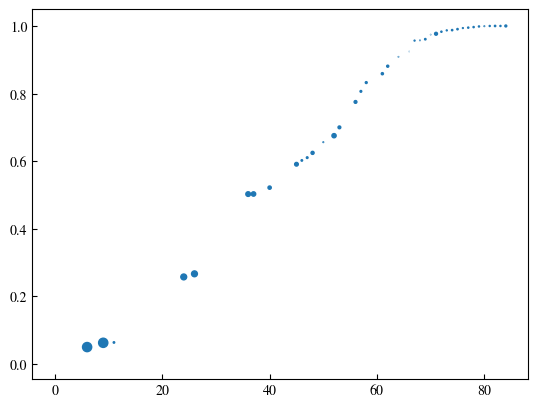

In [ ]:
plt.scatter(np.arange(0,stereotyps.__len__(),1),entropies_clusters[np.argsort(entropies_clusters)],s=slow_mode[np.argsort(entropies_clusters)]*500)#ss[np.argsort(entropies_clusters)]*500)

In [ ]:
classification = {'straight':0,'cast_and_surge':0}
for i in range(slow_mode.shape[0]):
    for key in stereotyps[i].keys():
        classification[key]+=stereotyps[i][key] * slow_mode[i]
print(classification)

{'straight': 0.45178978348081866, 'cast_and_surge': -0.45178978347994386}
